# Feature Engineering for Customer Churn (Online Retail)

This notebook turns cleaned transaction logs into **customer-level ML features** and a **binary churn label**.

**Goal**  
Build a table where each row is a customer and the target is:

- `is_churned = 1` → customer did **not** purchase during the churn window  
- `is_churned = 0` → customer **did** purchase during the churn window

⚠️ To avoid leakage, all numeric features are computed **only from the observation window**.


In [3]:
# Core libs
from __future__ import annotations

import numpy as np
import pandas as pd

from pathlib import Path
from dataclasses import dataclass
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)
sns.set_theme(style="whitegrid")


## 1) Configuration

Update the paths if your folder layout is different.


In [4]:
@dataclass(frozen=True)
class Config:
    # input
    cleaned_csv: Path = Path("../data/processed/online_retail_cleaned.csv")
    # output
    features_csv: Path = Path("../data/processed/customer_features_v2.csv")

    # time windows
    churn_window_days: int = 90        # last ~3 months
    min_history_days: int = 7          # optional: drop customers with super tiny history

CFG = Config()
CFG


Config(cleaned_csv=WindowsPath('../data/processed/online_retail_cleaned.csv'), features_csv=WindowsPath('../data/processed/customer_features_v2.csv'), churn_window_days=90, min_history_days=7)

## 2) Load cleaned transactions

In [5]:
from pathlib import Path
import pandas as pd

def load_transactions(path: Path) -> pd.DataFrame:
    if not Path(path).exists():
        raise FileNotFoundError(f"File not found: {Path(path).resolve()}")

    df = pd.read_csv(path)

    # keep original for debugging
    original_cols = df.columns.tolist()

    # normalize for matching
    norm = (
        pd.Index(df.columns)
        .astype(str)
        .str.strip()
        .str.lower()
        .str.replace(" ", "", regex=False)
        .str.replace("_", "", regex=False)
        .str.replace("-", "", regex=False)
    )
    norm_map = dict(zip(norm, df.columns))  # normalized -> original

    # helper to find first matching candidate
    def pick(*candidates):
        for c in candidates:
            if c in norm_map:
                return norm_map[c]
        return None

    # auto-detect columns (covers many real-world variants)
    col_invoice_date = pick("invoicedate", "invoice_date", "date", "transactiondate")
    col_customer     = pick("customerid", "customer_id", "custid", "customer", "clientid")
    col_qty          = pick("quantity", "qty", "count", "units")
    col_unitprice    = pick("unitprice", "unit_price", "price", "unitcost", "rate", "unitamount")

    # show what we detected
    print("✅ Original columns:", original_cols)
    print("✅ Detected mapping:", {
        "InvoiceDate": col_invoice_date,
        "CustomerID": col_customer,
        "Quantity": col_qty,
        "UnitPrice": col_unitprice
    })

    # rename into standard names
    rename_dict = {}
    if col_invoice_date: rename_dict[col_invoice_date] = "InvoiceDate"
    if col_customer:     rename_dict[col_customer]     = "CustomerID"
    if col_qty:          rename_dict[col_qty]          = "Quantity"
    if col_unitprice:    rename_dict[col_unitprice]    = "UnitPrice"

    df = df.rename(columns=rename_dict)

    required = {"InvoiceDate", "CustomerID", "Quantity", "UnitPrice"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(
            f"Missing required columns after mapping: {sorted(missing)}\n"
            f"Available columns now: {df.columns.tolist()}\n"
            f"Tip: Check your cleaned CSV generation step — it may have dropped these columns."
        )

    # conversions
    df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")
    df = df.dropna(subset=["InvoiceDate", "CustomerID"])

    # CustomerID to int safely
    df["CustomerID"] = pd.to_numeric(df["CustomerID"], errors="coerce")
    df = df.dropna(subset=["CustomerID"])
    df["CustomerID"] = df["CustomerID"].astype(int)

    # UnitPrice and Quantity numeric
    df["UnitPrice"] = pd.to_numeric(df["UnitPrice"], errors="coerce")
    df["Quantity"]  = pd.to_numeric(df["Quantity"], errors="coerce")

    return df
df_transactions = load_transactions(CFG.cleaned_csv)
print(f"✅ Loaded transactions: {df_transactions.shape[0]} rows x {df_transactions.shape[1]} columns")

✅ Original columns: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer_ID', 'Country', 'TotalPrice']
✅ Detected mapping: {'InvoiceDate': 'InvoiceDate', 'CustomerID': 'Customer_ID', 'Quantity': 'Quantity', 'UnitPrice': 'Price'}
✅ Loaded transactions: 805549 rows x 9 columns


## 3) Define observation vs churn windows

In [6]:
# Anchor on the last day in the dataset
data_end = df_transactions["InvoiceDate"].max().normalize()
churn_start = (data_end - pd.Timedelta(days=CFG.churn_window_days)).normalize()

# Observation window = everything before churn_start
df_obs = df_transactions[df_transactions["InvoiceDate"] < churn_start].copy()
df_churn = df_transactions[df_transactions["InvoiceDate"] >= churn_start].copy()

print("Data end:", data_end.date())
print("Churn window start:", churn_start.date())
print("Observation rows:", len(df_obs))
print("Churn-window rows:", len(df_churn))


Data end: 2011-12-09
Churn window start: 2011-09-10
Observation rows: 644022
Churn-window rows: 161527


## 4) Build customer-level features (from observation window only)

We compute:
- **Recency** (days since last purchase)
- **Frequency** (# unique invoices)
- **Monetary** (total spend)
- **Tenure** (days between first and last purchase)
- **Avg basket value** (avg spend per invoice)
- **Avg item price**
- **Unique products**
- **Return rate** (if returns exist as negative quantity)
- **Inter-purchase gap stats** (mean/median days between purchases)


In [7]:
# Create a transaction-level total line price
df_obs["line_amount"] = df_obs["Quantity"] * df_obs["UnitPrice"]

# Helper: safe division
def safe_div(n, d):
    return np.where(d == 0, 0.0, n / d)

# Invoice-level spend within observation window
invoice_cols = ["CustomerID", "InvoiceNo"] if "InvoiceNo" in df_obs.columns else ["CustomerID"]
inv = (
    df_obs
    .groupby(invoice_cols, as_index=False)
    .agg(
        invoice_date=("InvoiceDate", "max"),
        invoice_amount=("line_amount", "sum"),
        items=("Quantity", "sum"),
    )
)

# Customer purchase dates
cust_dates = (
    df_obs
    .groupby("CustomerID")
    .agg(first_purchase=("InvoiceDate", "min"), last_purchase=("InvoiceDate", "max"))
)

# Inter-purchase gaps: compute from sorted invoice dates per customer
inv_sorted = inv.sort_values(["CustomerID", "invoice_date"]).copy()
inv_sorted["prev_invoice_date"] = inv_sorted.groupby("CustomerID")["invoice_date"].shift(1)
inv_sorted["gap_days"] = (inv_sorted["invoice_date"] - inv_sorted["prev_invoice_date"]).dt.days

gap_stats = (
    inv_sorted
    .groupby("CustomerID")
    .agg(
        gap_mean=("gap_days", "mean"),
        gap_median=("gap_days", "median"),
        gap_std=("gap_days", "std"),
        invoices=("invoice_date", "count"),
    )
)

# Core RFM + extended spend features
rfm = (
    inv
    .groupby("CustomerID")
    .agg(
        Frequency=("invoice_amount", "count"),
        Monetary=("invoice_amount", "sum"),
        avg_basket_value=("invoice_amount", "mean"),
        avg_items_per_invoice=("items", "mean"),
        last_invoice_date=("invoice_date", "max"),
    )
)

# Recency based on churn_start (end of observation)
rfm["Recency"] = (churn_start - rfm["last_invoice_date"].dt.normalize()).dt.days

# Tenure
cust_dates["Tenure"] = (cust_dates["last_purchase"] - cust_dates["first_purchase"]).dt.days

# Product variety + pricing
extra = {}
if "StockCode" in df_obs.columns:
    extra["unique_products"] = df_obs.groupby("CustomerID")["StockCode"].nunique()

extra["avg_unit_price"] = df_obs.groupby("CustomerID")["UnitPrice"].mean()

# Returns proxy: negative Quantity implies return (common in Online Retail)
returns = df_obs.groupby("CustomerID")["Quantity"].apply(lambda s: (s < 0).sum()).rename("return_lines")
total_lines = df_obs.groupby("CustomerID")["Quantity"].size().rename("total_lines")
return_rate = (returns / total_lines).fillna(0).rename("return_rate")

df_features = (
    rfm
    .join(cust_dates["Tenure"], how="left")
    .join(gap_stats[["gap_mean","gap_median","gap_std"]], how="left")
    .join(pd.DataFrame(extra), how="left")
    .join(return_rate, how="left")
    .reset_index()
)

# Clean-up helpers
df_features = df_features.drop(columns=["last_invoice_date"])
df_features["gap_mean"] = df_features["gap_mean"].fillna(0)
df_features["gap_median"] = df_features["gap_median"].fillna(0)
df_features["gap_std"] = df_features["gap_std"].fillna(0)

print(df_features.shape)
df_features.head()


(5281, 13)


,CustomerID,Frequency,Monetary,avg_basket_value,avg_items_per_invoice,Recency,Tenure,gap_mean,gap_median,gap_std,unique_products,avg_unit_price,return_rate
0,12346,1,77556.46,77556.46,74285.0,235,400,0.0,0.0,0.0,27,6.100000,0.0
1,12347,1,4114.18,4114.18,2418.0,39,274,0.0,0.0,0.0,107,2.614667,0.0
2,12348,1,1709.40,1709.40,2497.0,158,189,0.0,0.0,0.0,25,3.137500,0.0
3,12349,1,2671.14,2671.14,993.0,317,181,0.0,0.0,0.0,90,8.581765,0.0
4,12350,1,334.40,334.40,197.0,220,0,0.0,0.0,0.0,17,3.841176,0.0


## 5) Create churn label

In [8]:
# Customers active during churn window are NOT churned (0)
active_in_churn = set(df_churn["CustomerID"].unique())

df_features["is_churned"] = (~df_features["CustomerID"].isin(active_in_churn)).astype(int)

df_features["is_churned"].value_counts(dropna=False)


is_churned
1    2989
0    2292
Name: count, dtype: int64

## 6) Optional: add a primary country feature (mode) + one-hot encode

In [9]:
if "Country" in df_obs.columns:
    primary_country = (
        df_obs.groupby("CustomerID")["Country"]
        .agg(lambda s: s.mode().iloc[0] if len(s.mode()) else s.iloc[0])
        .rename("PrimaryCountry")
    )
    df_features = df_features.merge(primary_country, on="CustomerID", how="left")
    # One-hot encode with a controlled set of top countries
    top_k = 8
    top_countries = df_features["PrimaryCountry"].value_counts().head(top_k).index
    df_features["PrimaryCountry"] = df_features["PrimaryCountry"].where(
        df_features["PrimaryCountry"].isin(top_countries),
        other="Other"
    )
    dummies = pd.get_dummies(df_features["PrimaryCountry"], prefix="Country")
    df_features = pd.concat([df_features.drop(columns=["PrimaryCountry"]), dummies], axis=1)

df_features.head()


,CustomerID,Frequency,Monetary,avg_basket_value,avg_items_per_invoice,Recency,Tenure,gap_mean,gap_median,gap_std,unique_products,avg_unit_price,return_rate,is_churned,Country_Belgium,Country_France,Country_Germany,Country_Netherlands,Country_Other,Country_Portugal,Country_Spain,Country_Switzerland,Country_United Kingdom
0,12346,1,77556.46,77556.46,74285.0,235,400,0.0,0.0,0.0,27,6.100000,0.0,1,False,False,False,False,False,False,False,False,True
1,12347,1,4114.18,4114.18,2418.0,39,274,0.0,0.0,0.0,107,2.614667,0.0,0,False,False,False,False,True,False,False,False,False
2,12348,1,1709.40,1709.40,2497.0,158,189,0.0,0.0,0.0,25,3.137500,0.0,0,False,False,False,False,True,False,False,False,False
3,12349,1,2671.14,2671.14,993.0,317,181,0.0,0.0,0.0,90,8.581765,0.0,0,False,False,False,False,True,False,False,False,False
4,12350,1,334.40,334.40,197.0,220,0,0.0,0.0,0.0,17,3.841176,0.0,1,False,False,False,False,True,False,False,False,False


## 7) Quick sanity checks

In [10]:
# Any negative monetary? (could happen with returns; keep but review)
summary = df_features[["Recency","Frequency","Monetary","Tenure","avg_basket_value","avg_unit_price","return_rate","is_churned"]].describe().T
summary


,count,mean,std,min,25%,50%,75%,max
Recency,5281.0,207.814240,175.029112,1.000000,50.000000,164.000000,327.00000,648.0
Frequency,5281.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.00000,1.0
Monetary,5281.0,2705.436178,12535.825033,2.900000,323.860000,804.020000,2118.75000,484615.1
Tenure,5281.0,224.148457,218.803611,0.000000,0.000000,170.000000,417.00000,646.0
avg_basket_value,5281.0,2705.436178,12535.825033,2.900000,323.860000,804.020000,2118.75000,484615.1
avg_unit_price,5281.0,8.853406,183.909512,0.151333,2.318861,3.004902,3.92208,10953.5
return_rate,5281.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0
is_churned,5281.0,0.565991,0.495673,0.000000,0.000000,1.000000,1.00000,1.0


In [11]:
# Ensure no leakage columns from churn window are present (everything here built from df_obs)
assert "InvoiceDate" not in df_features.columns

# Check duplicates
dup = df_features["CustomerID"].duplicated().sum()
print("Duplicate customers:", dup)

# Optional: drop customers with extremely low history
if CFG.min_history_days is not None:
    before = len(df_features)
    df_features = df_features[df_features["Tenure"] >= CFG.min_history_days].copy()
    after = len(df_features)
    print(f"Dropped {before-after} customers with Tenure < {CFG.min_history_days} days")


Duplicate customers: 0
Dropped 1693 customers with Tenure < 7 days


## 8) EDA Plots on engineered features (3–6 useful visuals)

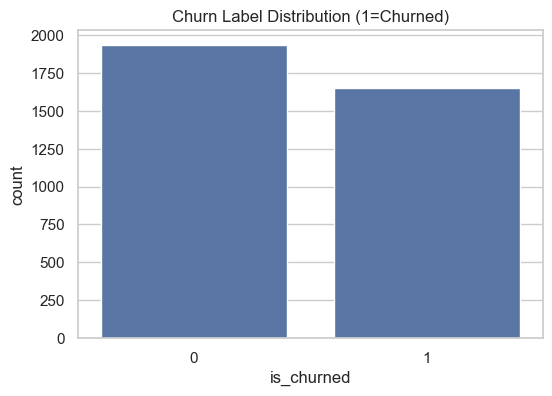

In [12]:
# 1) Churn distribution
plt.figure(figsize=(6,4))
sns.countplot(x="is_churned", data=df_features)
plt.title("Churn Label Distribution (1=Churned)")
plt.show()


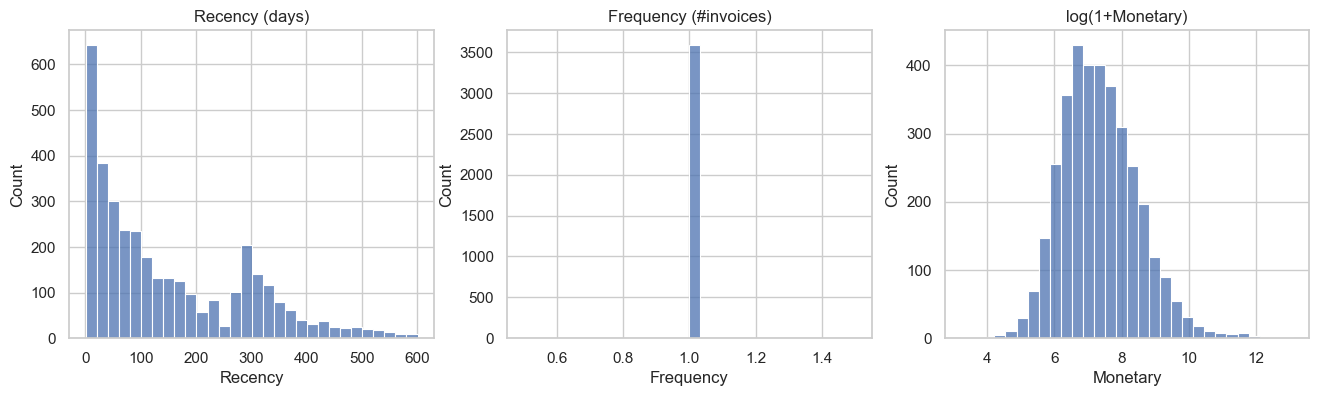

In [13]:
# 2) RFM distributions (log scale for Monetary if skewed)
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
sns.histplot(df_features["Recency"], bins=30, ax=axes[0])
axes[0].set_title("Recency (days)")

sns.histplot(df_features["Frequency"], bins=30, ax=axes[1])
axes[1].set_title("Frequency (#invoices)")

sns.histplot(np.log1p(df_features["Monetary"].clip(lower=0)), bins=30, ax=axes[2])
axes[2].set_title("log(1+Monetary)")
plt.show()


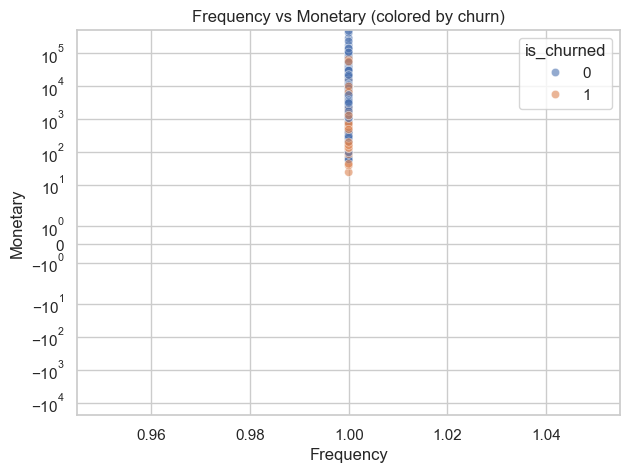

In [14]:
# 3) Monetary vs Frequency colored by churn
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=df_features,
    x="Frequency",
    y="Monetary",
    hue="is_churned",
    alpha=0.6
)
plt.title("Frequency vs Monetary (colored by churn)")
plt.yscale("symlog")
plt.show()


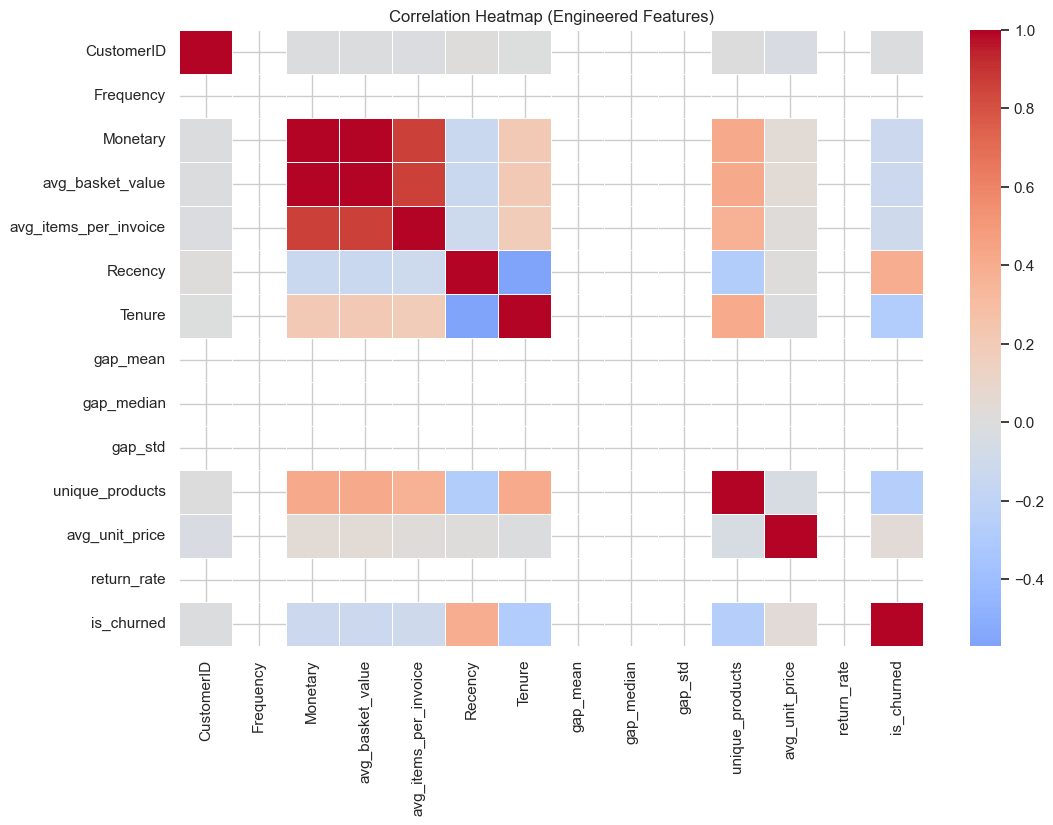

In [15]:
# 4) Correlation heatmap (numeric only)
num_cols = df_features.select_dtypes(include="number").columns
corr = df_features[num_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Correlation Heatmap (Engineered Features)")
plt.show()


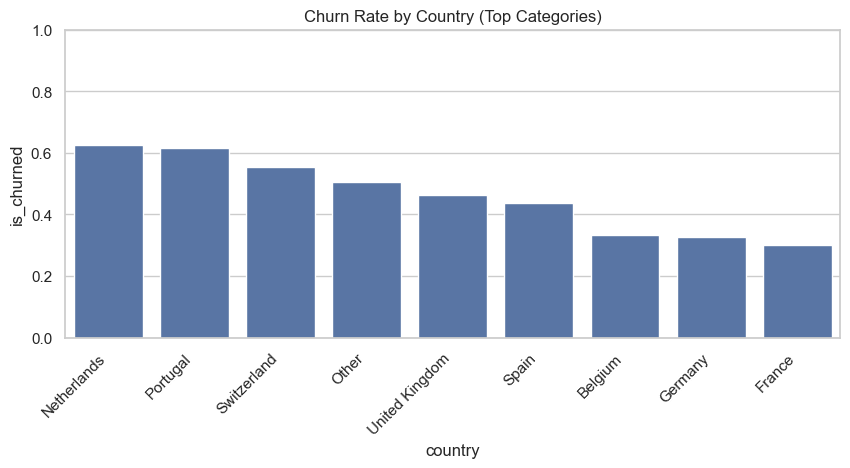

In [16]:
# 5) Churn rate by top countries (if one-hot exists)
country_cols = [c for c in df_features.columns if c.startswith("Country_")]
if country_cols:
    # rebuild a readable country label
    df_tmp = df_features[["is_churned"] + country_cols].copy()
    df_tmp["country"] = df_tmp[country_cols].idxmax(axis=1).str.replace("Country_", "", regex=False)

    churn_by_country = (
        df_tmp.groupby("country")["is_churned"]
        .mean()
        .sort_values(ascending=False)
        .reset_index()
    )

    plt.figure(figsize=(10,4))
    sns.barplot(data=churn_by_country, x="country", y="is_churned")
    plt.title("Churn Rate by Country (Top Categories)")
    plt.xticks(rotation=45, ha="right")
    plt.ylim(0, 1)
    plt.show()


## 9) Save feature table

In [17]:
CFG.features_csv.parent.mkdir(parents=True, exist_ok=True)
df_features.to_csv(CFG.features_csv, index=False)

print("Saved:", CFG.features_csv.resolve())
print("Shape:", df_features.shape)


Saved: C:\Users\abhin\ai-systems-foundations\DeepLearningProject\data\processed\customer_features_v2.csv
Shape: (3588, 23)


In [18]:
df_features.columns

Index(['CustomerID', 'Frequency', 'Monetary', 'avg_basket_value', 'avg_items_per_invoice', 'Recency', 'Tenure', 'gap_mean', 'gap_median',
       'gap_std', 'unique_products', 'avg_unit_price', 'return_rate', 'is_churned', 'Country_Belgium', 'Country_France', 'Country_Germany',
       'Country_Netherlands', 'Country_Other', 'Country_Portugal', 'Country_Spain', 'Country_Switzerland', 'Country_United Kingdom'],
      dtype='str')

## Interview Questions (Feature Engineering & Leakage)

1. **How did you prevent data leakage when building churn features?**  
2. **Why is Recency computed relative to `churn_start` instead of the dataset end date?**  
3. **If Monetary is highly skewed, what transformations would you try and why?**  
4. **How would you handle customers with returns (negative quantities) in Monetary?**  
5. **What does class imbalance mean and how do you detect it here?**  
6. **Why can one-hot encoding blow up feature space? What are alternatives?**  
7. **If you deploy this, how will you compute features for a new day of data?**  
8. **Which engineered feature do you expect to be most predictive of churn, and why?**  
9. **What checks would you add to ensure feature pipeline stability (data quality)?**  
10. **How would you validate that “gap_mean” is not accidentally using churn-window purchases?**
